# TS2Vec

TS2Vec 没有提供对应的 Python 库，我们从 GitHub 上拉取代码库，直接使用代码库的代码：

```
git clone https://github.com/zhihanyue/ts2vec.git
```

为项目创建一个新 conda 环境：

```
# 创建一个 Python3.8 环境
conda create -n py38 python=3.8

# 查看所有 conda 环境
conda info --envs

# 激活 Python3.8 环境
conda activate py38

# 为当前 Python 环境安装 ipykernel
python -m pip install ipykernel

# 将新环境加入 jupyter notebook kernel
python -m ipykernel install --user --name py38 --display-name "Python (py38)"
```

安装必要的 Python 库：

```
cd ts2vec
pip install -r requirements.txt
```

下载 UCR 数据集；并对 ts2vec 进行轻度改造，使其可在上层目录运行。

## 1. 生成序列 Embedding

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from ts2vec.ts2vec import TS2Vec
from ts2vec import datautils

import utils

In [2]:
# Load the ECG200 dataset from UCR archive
train_data, train_labels, test_data, test_labels = datautils.load_UCR('ECG200')
# (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)

print(f'train_data.shape: {train_data.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_data.shape: {test_data.shape}')
print(f'test_labels.shape: {test_labels.shape}')

train_data.shape: (100, 96, 1)
train_labels.shape: (100,)
test_data.shape: (100, 96, 1)
test_labels.shape: (100,)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Train a TS2Vec model
model = TS2Vec(
    input_dims=1,
    device=device,
    output_dims=256
)
loss_log = model.fit(
    train_data,
    verbose=True
)

Epoch #0: loss=6.587682485580444
Epoch #1: loss=2.798020839691162
Epoch #2: loss=2.8615644375483194
Epoch #3: loss=2.705299973487854
Epoch #4: loss=2.502809206644694
Epoch #5: loss=2.493217706680298
Epoch #6: loss=2.409266948699951
Epoch #7: loss=2.4758692185084024
Epoch #8: loss=2.331478397051493
Epoch #9: loss=2.3794921239217124
Epoch #10: loss=2.2052005728085837
Epoch #11: loss=2.225045084953308
Epoch #12: loss=2.231028735637665
Epoch #13: loss=2.077696442604065
Epoch #14: loss=2.0885844230651855
Epoch #15: loss=2.093023975690206
Epoch #16: loss=1.9834290544191997
Epoch #17: loss=1.9088496764500935
Epoch #18: loss=1.9954955379168193
Epoch #19: loss=1.862285077571869
Epoch #20: loss=1.9263519843419392
Epoch #21: loss=1.8634540438652039
Epoch #22: loss=1.8537902037302654
Epoch #23: loss=2.041041612625122
Epoch #24: loss=2.0363448659578958
Epoch #25: loss=2.0408048033714294
Epoch #26: loss=1.9404139916102092
Epoch #27: loss=1.8741823434829712
Epoch #28: loss=1.752505401770274
Epoch #29

In [4]:
# Compute timestamp-level representations for test set
test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims

test_repr.shape

(100, 96, 256)

In [5]:
# Compute instance-level representations for test set
test_repr = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims

test_repr.shape

(100, 256)

In [6]:
# Sliding inference for test set
test_repr = model.encode(
    test_data,
    causal=True,
    sliding_length=1,
    sliding_padding=50
)  # n_instances x n_timestamps x output_dims
# (The timestamp t's representation vector is computed using the observations located in [t-50, t])

test_repr.shape

(100, 96, 256)

## 2. 降维 & 可视化

In [7]:
tsne = TSNE(n_components=2,
            perplexity=10,
            random_state=42,
            init='pca',
            learning_rate=100)

In [8]:
# reshape test_data
dim_1, dim_2, _ = test_data.shape
raw_test_repr = test_data.reshape(dim_1, dim_2)

# 对原始时间序列数据降维
raw_vis_dims = tsne.fit_transform(raw_test_repr)
raw_vis_dims.shape

(100, 2)

In [9]:
# 使用 TS2Vec 生成时间序列的 Embedding
instance_test_repr = model.encode(test_data, encoding_window='full_series')

# 对 TS2Vec 生成的 Embedding 降维
instance_vis_dims = tsne.fit_transform(instance_test_repr)
instance_vis_dims.shape

(100, 2)

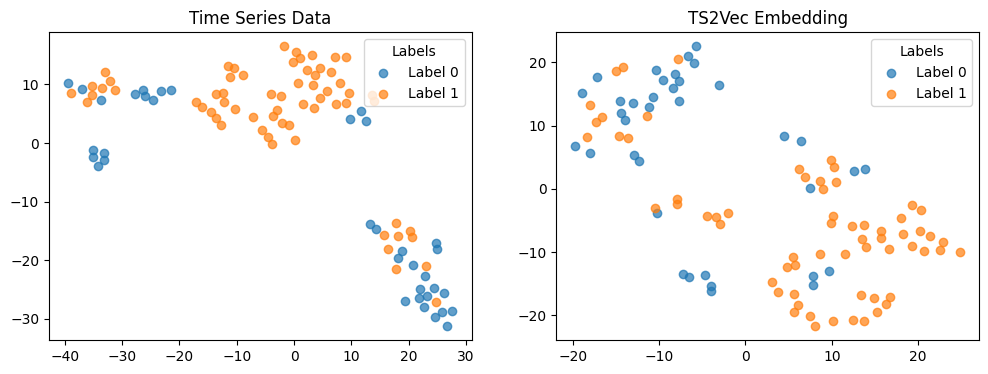

In [10]:
x_raw = raw_vis_dims[:,0]
y_raw = raw_vis_dims[:,1]
x_ins = instance_vis_dims[:,0]
y_ins = instance_vis_dims[:,1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# 原始时间序列数据降维后的图像
for label in np.unique(test_labels):
    ax1.scatter(x_raw[test_labels == label],
                y_raw[test_labels == label],
                label=f'Label {label}',
                alpha=0.7)
ax1.set_title('Time Series Data')
ax1.legend(title='Labels', loc='upper right')

# TS2Vec 生成的 Embedding 降维后的图像
for label in np.unique(test_labels):
    ax2.scatter(x_ins[test_labels == label],
                y_ins[test_labels == label],
                label=f'Label {label}',
                alpha=0.7)
ax2.set_title('TS2Vec Embedding')
ax2.legend(title='Labels', loc='upper right')
plt.show()

## 3. 训练 MLP

### 3.1 用 TS2Vec 生成的 Embedding 训练 MLP

In [11]:
df_repr = pd.DataFrame({
    'test_repr': [e for e in instance_test_repr],
    'test_label': test_labels
})
df_repr

,test_repr,test_label
0,"[0.38373172, 0.29156172, 0.11338271, 0.1347958...",1
1,"[0.3837579, 0.29279637, 0.1051202, 0.180955, 0...",1
2,"[0.30830595, 0.23394734, 0.23617649, 0.1785982...",1
3,"[0.40421963, 0.28111237, 0.16077678, 0.0966127...",1
4,"[0.2488335, 0.21594605, 0.18202583, 0.22806622...",0
...,...,...
95,"[0.3694303, 0.30677834, 0.12844628, 0.15508384...",1
96,"[0.36262527, 0.27609172, 0.099352516, 0.159239...",1
97,"[0.2999612, 0.1957323, 0.20148599, 0.20709246,...",0
98,"[0.37347305, 0.30264038, 0.16175807, 0.1609858...",0


train_loss: 0.5900
train_acc: 0.7
test_acc: 0.65


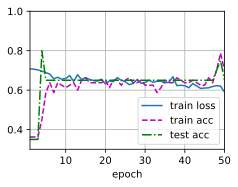

In [12]:
mlp = utils.MLP(input_channel=instance_test_repr.shape[1],
                output_channel=2,
                hidden_num_1=128,
                hidden_num_2=32,
                batch_size=16,
                num_epochs=50)

y_pred, metric = mlp(df=df_repr,
                     embd_col_name='test_repr',
                     label_col_name='test_label')

print(f'train_loss: {metric["train_loss"]:.4f}')
print(f'train_acc: {metric["train_acc"]}')
print(f'test_acc: {metric["test_acc"]}')

In [13]:
y_pred[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### 3.2 用原始时间序列数据训练 MLP

In [14]:
df_raw = pd.DataFrame({
    'test_repr': [e for e in raw_test_repr],
    'test_label': test_labels
})
df_raw

,test_repr,test_label
0,"[0.42518938, 1.4185988, 2.6687913, 3.298629, 2...",1
1,"[0.65392929, 2.1772899, 3.6447828, 2.2792033, ...",1
2,"[0.4049532, 0.55399598, 0.72409707, 1.4490394,...",1
3,"[1.0880883, 2.0119486, 2.3017332, 1.6301994, 0...",1
4,"[0.44362091, 0.94728503, 1.9240844, 2.1597897,...",0
...,...,...
95,"[0.8438343, 2.5647645, 3.3431272, 2.5918108, 1...",1
96,"[1.3984722, 2.8747708, 3.4534283, 2.8979189, 1...",1
97,"[1.1136848, 1.2759515, 1.1717696, 1.5545506, 2...",0
98,"[2.3182077, 2.1397723, 1.7942428, 2.3445082, 1...",0


train_loss: 0.4235
train_acc: 0.925
test_acc: 0.85


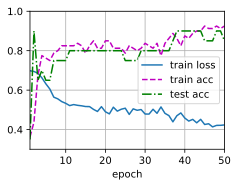

In [15]:
mlp = utils.MLP(input_channel=raw_test_repr.shape[1],
                output_channel=2,
                hidden_num_1=128,
                hidden_num_2=32,
                batch_size=16,
                num_epochs=50)

y_pred, metric = mlp(df=df_raw,
                     embd_col_name='test_repr',
                     label_col_name='test_label')

print(f'train_loss: {metric["train_loss"]:.4f}')
print(f'train_acc: {metric["train_acc"]}')
print(f'test_acc: {metric["test_acc"]}')

In [16]:
y_pred[:10]

[1, 1, 0, 1, 0, 1, 1, 1, 1, 0]